Quantitative Analysis of Price & Daily returns
 - Can returns be described with a normal distribution?
 - Is there directional bias in daily change?
 - Can price movement be desctibed as a random walk?

In [1]:
#1.Set up environment
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import datetime
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()

In [2]:
#2.Download Stock price data, store the dataFrame
def get_stock_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    return data

start = datetime(2020, 1, 1)
end = datetime(2023, 7, 31)
amzn_data = get_stock_data("AMZN", start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
amzn_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000


In [4]:
#3.Store instantaneous rate of return in separate series
amzn = get_stock_data("AMZN", start, end)
amzn_close = amzn['Close']
#amzn_return = np.log(amzn_close).diff()
amzn_return = round(np.log(amzn_close).diff() * 100, 2)
amzn_return.head()

[*********************100%***********************]  1 of 1 completed


Date
2020-01-02     NaN
2020-01-03   -1.22
2020-01-06    1.48
2020-01-07    0.21
2020-01-08   -0.78
Name: Close, dtype: float64

<Axes: xlabel='Date'>

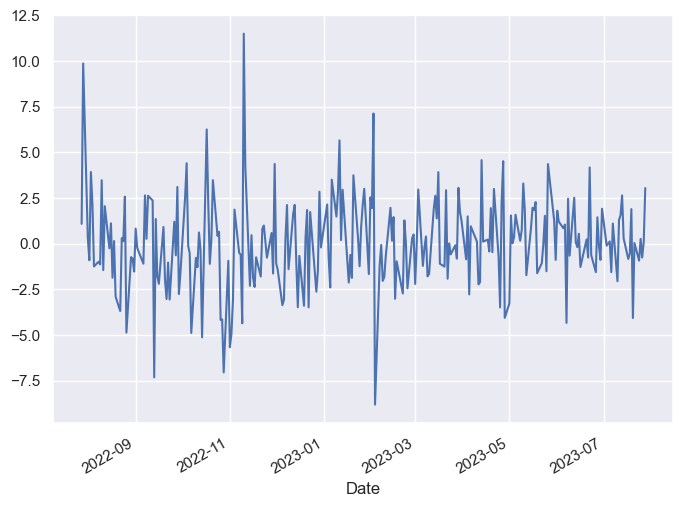

In [5]:
#4.Plot the series
amzn_return[-252:].plot()

In [6]:
#5.Pandas describe funtion gives descriptive statustucs, default assumens you are dealing with a sample Pandas also deals with missing values by omitting them
amzn_return.dropna(inplace = True)
amzn_return.describe()

count    898.000000
mean       0.036938
std        2.419281
min      -15.140000
25%       -1.237500
50%        0.080000
75%        1.327500
max       12.690000
Name: Close, dtype: float64

In [7]:
#An alternative more slightly different table of descriptives from scipy stats
from scipy import stats
n, minmax, mean, var, skew, kurt = stats.describe(amzn_return)
mini, maxi = minmax
std = var ** .5

In [8]:
#For comparision generate random numbers that follow normal distribution
from scipy.stats import norm

(array([  1.,   0.,   0.,   6.,   4.,  28.,  93., 242., 335., 125.,  48.,
         12.,   1.,   1.,   2.]),
 array([-15.14      , -13.28466667, -11.42933333,  -9.574     ,
         -7.71866667,  -5.86333333,  -4.008     ,  -2.15266667,
         -0.29733333,   1.558     ,   3.41333333,   5.26866667,
          7.124     ,   8.97933333,  10.83466667,  12.69      ]),
 <BarContainer object of 15 artists>)

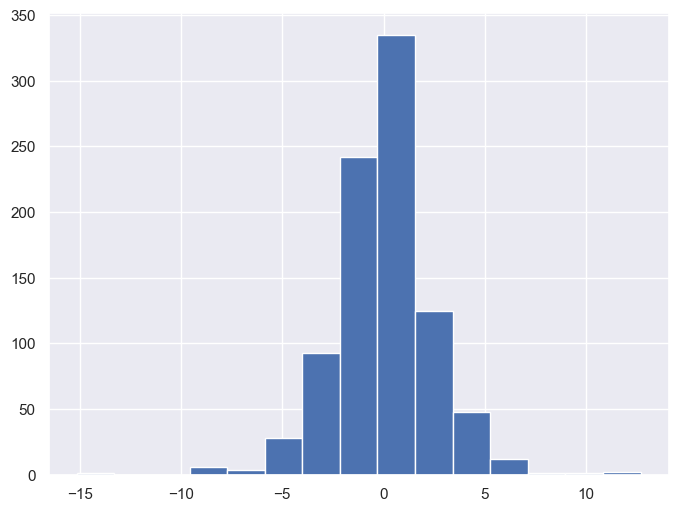

In [9]:
plt.hist(amzn_return, bins = 15)

In [10]:
from scipy.stats import norm
x = norm.rvs(mean, std, n)

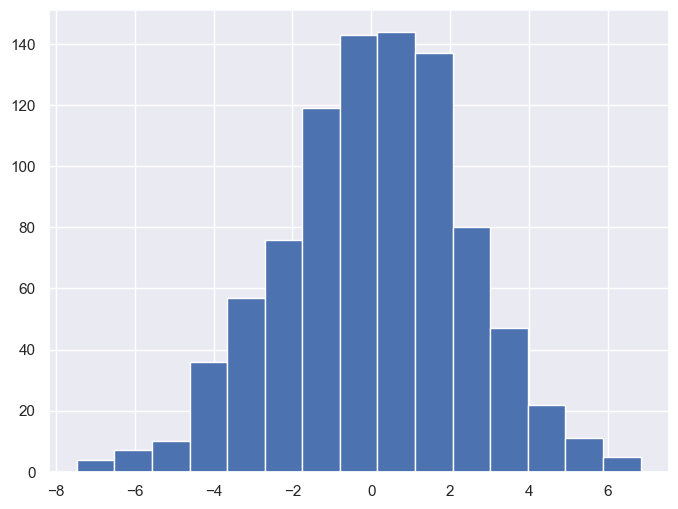

In [11]:
plt.hist(x, bins =15);

Is price change normally distributed?
Use scipy stats to test the kurtosis, the null hypothesis is that the sample is drawn from a population where the underlying kurtosis is that of a normally distributed variable


In [12]:
x_test = stats.kurtosistest(x)
amzn_test = stats.kurtosistest(amzn_return)
print(f'{"     Test statistic":20}{"p-value":>15}')
print(f'{" "*5}{"_"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"AMZN:{amzn_test[0]:13.2f}{amzn_test[1]:16.4f}")

     Test statistic         p-value
     ______________________________
x:             0.12          0.9052
AMZN:         9.18          0.0000


Plot histogram of price changes with normal curve overlay

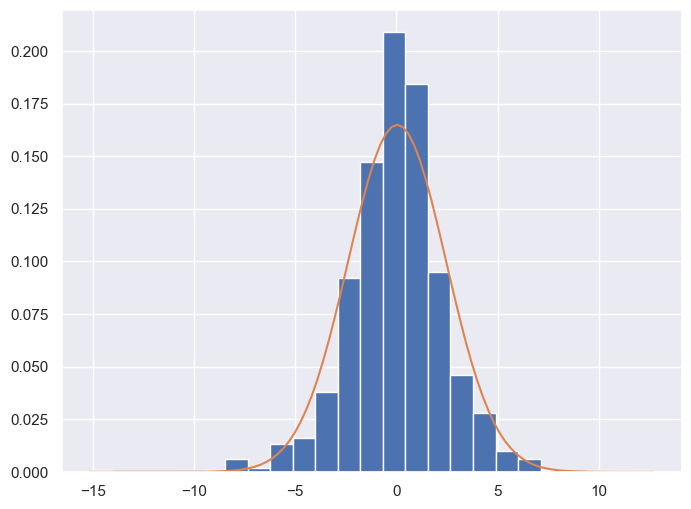

In [13]:
plt.hist(amzn_return, bins = 25, edgecolor= 'w', density = True)
overlay = np.linspace(mini, maxi, 100)
plt.plot(overlay, norm.pdf(overlay, mean, std));

Is daily price change significantly different from zero?

Conduct simple hypothesis test

In [14]:
stats.ttest_1samp(amzn_return, 0, alternative = 'two-sided')

TtestResult(statistic=0.45753153452290624, pvalue=0.6473998382383506, df=897)

Can price movement be described as a random walk?

Create price lags

In [15]:
amzn_close = pd.DataFrame(amzn.Close, columns= ['Close'])
amzn_close['lag_1'] = amzn_close.Close.shift(1)
amzn_close['lag_2'] = amzn_close.Close.shift(2)
amzn_close.dropna(inplace = True)
amzn_close.head()

,Close,lag_1,lag_2
Date,,,
2020-01-06,95.143997,93.748497,94.900497
2020-01-07,95.343002,95.143997,93.748497
2020-01-08,94.598503,95.343002,95.143997
2020-01-09,95.052498,94.598503,95.343002
2020-01-10,94.157997,95.052498,94.598503


Fit linear model

In [16]:
lr = np.linalg.lstsq(amzn_close[['lag_1', 'lag_2']], amzn_close.Close, rcond=None)[0]


In [17]:
amzn_close['predict'] = np.dot(amzn_close[['lag_1', 'lag_2']], lr)

In [18]:
amzn_close.head()

,Close,lag_1,lag_2,predict
Date,,,,
2020-01-06,95.143997,93.748497,94.900497,93.781885
2020-01-07,95.343002,95.143997,93.748497,95.104900
2020-01-08,94.598503,95.343002,95.143997,95.337955
2020-01-09,95.052498,94.598503,95.343002,94.620300
2020-01-10,94.157997,95.052498,94.598503,95.040193


<Axes: xlabel='Date'>

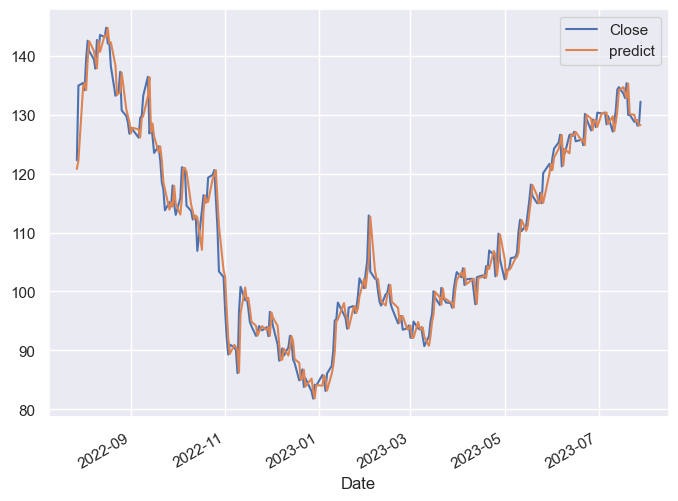

In [19]:
amzn_close.iloc[-252:][['Close', 'predict']].plot()